# Mall Customers Clustering (K-Means + DBSCAN)

**In-class exercise:** pull a CSV from GitHub, do quick EDA, then cluster the customers using **K-Means** and **DBSCAN**.

Dataset columns you should see:
- `CustomerID`
- `Gender`
- `Age`
- `Annual Income (k$)`
- `Spending Score (1-100)`

---

## Learning goals
1. Practice a lightweight EDA workflow (shape, types, missingness, basic plots).
2. Understand why scaling matters for distance-based clustering.
3. Use the **elbow method** to choose `k` for K-Means.
4. Run **DBSCAN** and interpret clusters vs. noise points.


## 1) Download the dataset 

In [16]:
#I think the following will work on both linux and a mac (-O is upper case o)
# !curl -O https://raw.githubusercontent.com/CNUClasses/DATA301_CODE/master/week_5/Mall_Customers.csv

In [17]:
# Download once (won't re-download if file exists)
import os, subprocess, shutil, urllib.request

DATA_URL = "https://raw.githubusercontent.com/CNUClasses/DATA301_CODE/master/week_5/Mall_Customers.csv"
DATA_PATH = "Mall_Customers.csv"

if os.path.exists(DATA_PATH):
    print(f"{DATA_PATH} already exists — skipping download.")
else:
    urllib.request.urlretrieve(DATA_URL, DATA_PATH)

Mall_Customers.csv already exists — skipping download.


## 2) Load the data

In [18]:

import pandas as pd

df = pd.read_csv("Mall_Customers.csv")
df.head()


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [19]:

df.shape, df.columns


((200, 5),
 Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
        'Spending Score (1-100)'],
       dtype='object'))

In [20]:

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [21]:

df.isna().sum()


CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

## 3) Simple exploratory analysis (EDA)

We’ll do just enough to understand the dataset:
- summary stats for numeric columns
- quick histograms
- a couple of scatter plots of likely clustering features


In [22]:

df.describe(include="all")


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200,200.000000,200.000000,200.000000
unique,NaN,2,NaN,NaN,NaN
top,NaN,Female,NaN,NaN,NaN
freq,NaN,112,NaN,NaN,NaN
mean,100.500000,NaN,38.850000,60.560000,50.200000
std,57.879185,NaN,13.969007,26.264721,25.823522
min,1.000000,NaN,18.000000,15.000000,1.000000
25%,50.750000,NaN,28.750000,41.500000,34.750000
50%,100.500000,NaN,36.000000,61.500000,50.000000
75%,150.250000,NaN,49.000000,78.000000,73.000000


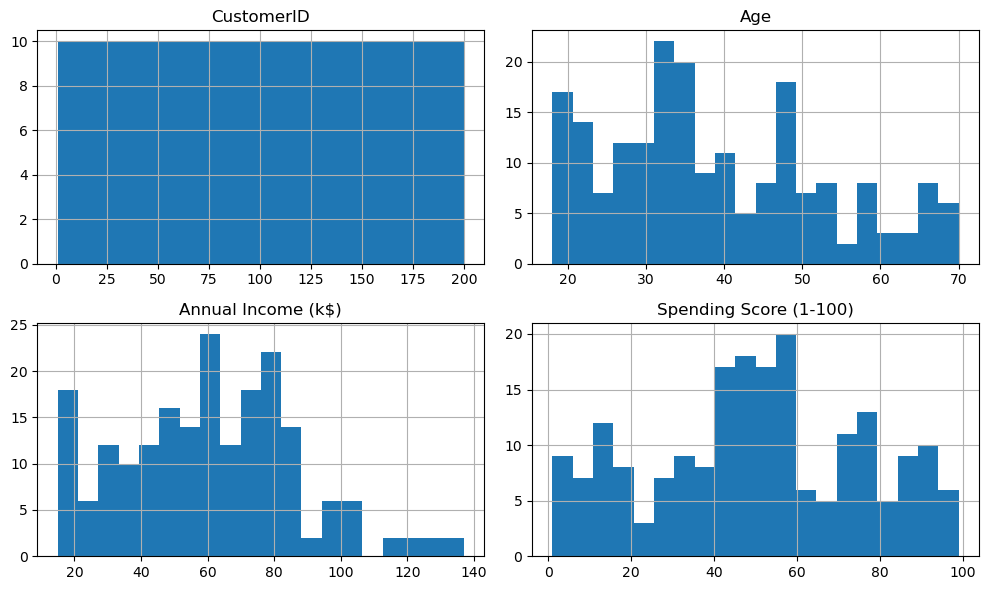

In [23]:

import matplotlib.pyplot as plt

numeric_cols = df.select_dtypes(include="number").columns
df[numeric_cols].hist(bins=20, figsize=(10,6))
plt.tight_layout()
plt.show()


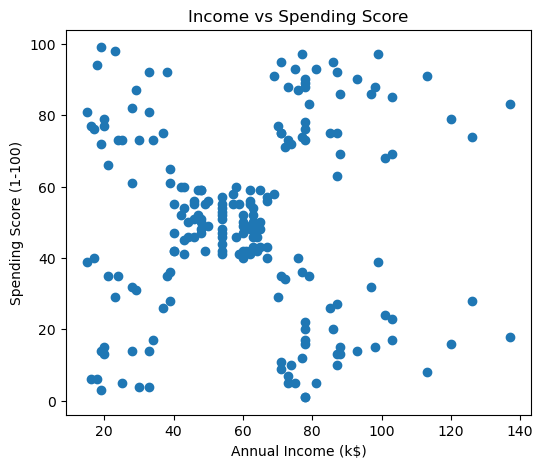

In [24]:

# A classic view for this dataset: Income vs Spending Score
plt.figure(figsize=(6,5))
plt.scatter(df["Annual Income (k$)"], df["Spending Score (1-100)"])
plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("Income vs Spending Score")
plt.show()


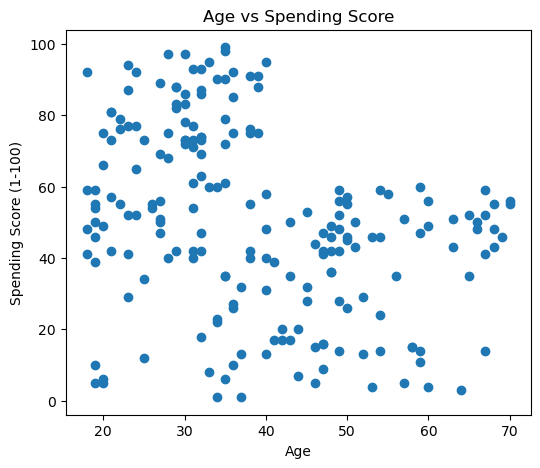

In [25]:

# Optional: Age vs Spending Score
plt.figure(figsize=(6,5))
plt.scatter(df["Age"], df["Spending Score (1-100)"])
plt.xlabel("Age")
plt.ylabel("Spending Score (1-100)")
plt.title("Age vs Spending Score")
plt.show()


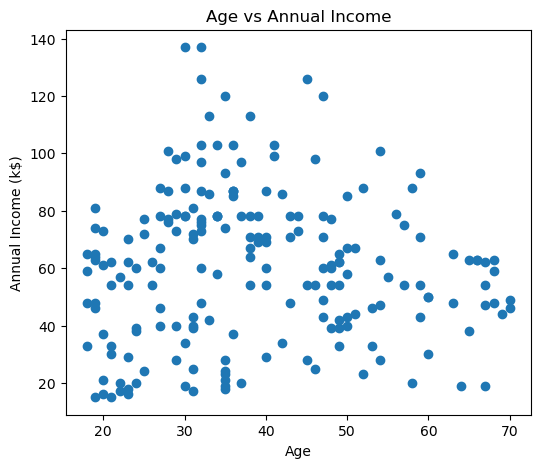

In [26]:
# Optional: Age vs Annual income
plt.figure(figsize=(6,5))
plt.scatter(df["Age"], df["Annual Income (k$)"])
plt.xlabel("Age")
plt.ylabel("Annual Income (k$)")
plt.title("Age vs Annual Income")
plt.show()


## 4) Prep features for clustering

K-Means/DBSCAN are distance-based, so scaling matters.

We'll:
1. One-hot encode `Gender`
2. Choose a feature set
3. Standardize features with `StandardScaler`


In [27]:

from sklearn.preprocessing import StandardScaler

# One-hot encode Gender
df_model = pd.get_dummies(df, columns=["Gender"], drop_first=True)

# Choose features (feel free to change for the exercise)
feature_cols = ["Age", "Annual Income (k$)", "Spending Score (1-100)", "Gender_Male"]

X = df_model[feature_cols].copy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled


array([[-1.42456879, -1.73899919, -0.43480148,  1.12815215],
       [-1.28103541, -1.73899919,  1.19570407,  1.12815215],
       [-1.3528021 , -1.70082976, -1.71591298, -0.88640526],
       [-1.13750203, -1.70082976,  1.04041783, -0.88640526],
       [-0.56336851, -1.66266033, -0.39597992, -0.88640526],
       [-1.20926872, -1.66266033,  1.00159627, -0.88640526],
       [-0.27630176, -1.62449091, -1.71591298, -0.88640526],
       [-1.13750203, -1.62449091,  1.70038436, -0.88640526],
       [ 1.80493225, -1.58632148, -1.83237767,  1.12815215],
       [-0.6351352 , -1.58632148,  0.84631002, -0.88640526],
       [ 2.02023231, -1.58632148, -1.4053405 ,  1.12815215],
       [-0.27630176, -1.58632148,  1.89449216, -0.88640526],
       [ 1.37433211, -1.54815205, -1.36651894, -0.88640526],
       [-1.06573534, -1.54815205,  1.04041783, -0.88640526],
       [-0.13276838, -1.54815205, -1.44416206,  1.12815215],
       [-1.20926872, -1.54815205,  1.11806095,  1.12815215],
       [-0.27630176, -1.

## 5) K-Means clustering

### 5.1 Elbow method
We’ll plot inertia (WCSS) vs. `k` and look for the “elbow.”


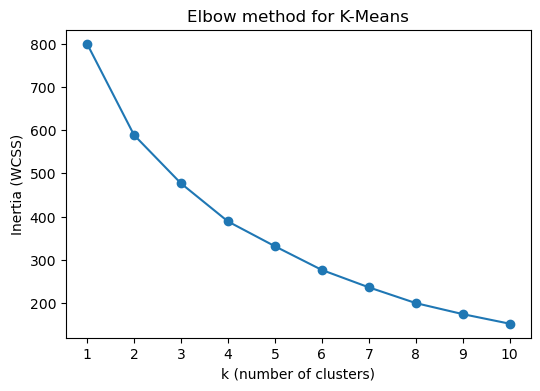

In [28]:

from sklearn.cluster import KMeans
import numpy as np

inertias = []
k_values = range(1, 11)

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,4))
plt.plot(list(k_values), inertias, marker="o")
plt.xticks(list(k_values))
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (WCSS)")
plt.title("Elbow method for K-Means")
plt.show()


### 5.2 Fit K-Means with a chosen `k`

Pick `k` from the elbow plot (common choices on this dataset are ~4–6 depending on features/scaling).


In [29]:

# TODO (students): change K based on the elbow plot
K = 3

kmeans = KMeans(n_clusters=K, n_init=10, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

df_out = df.copy()
df_out["kmeans_cluster"] = kmeans_labels
df_out["kmeans_cluster"].value_counts().sort_index()


kmeans_cluster
0    85
1    66
2    49
Name: count, dtype: int64

In [30]:
df_out.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),kmeans_cluster
0,1,Male,19,15,39,0
1,2,Male,21,15,81,0
2,3,Female,20,16,6,1
3,4,Female,23,16,77,0
4,5,Female,31,17,40,1


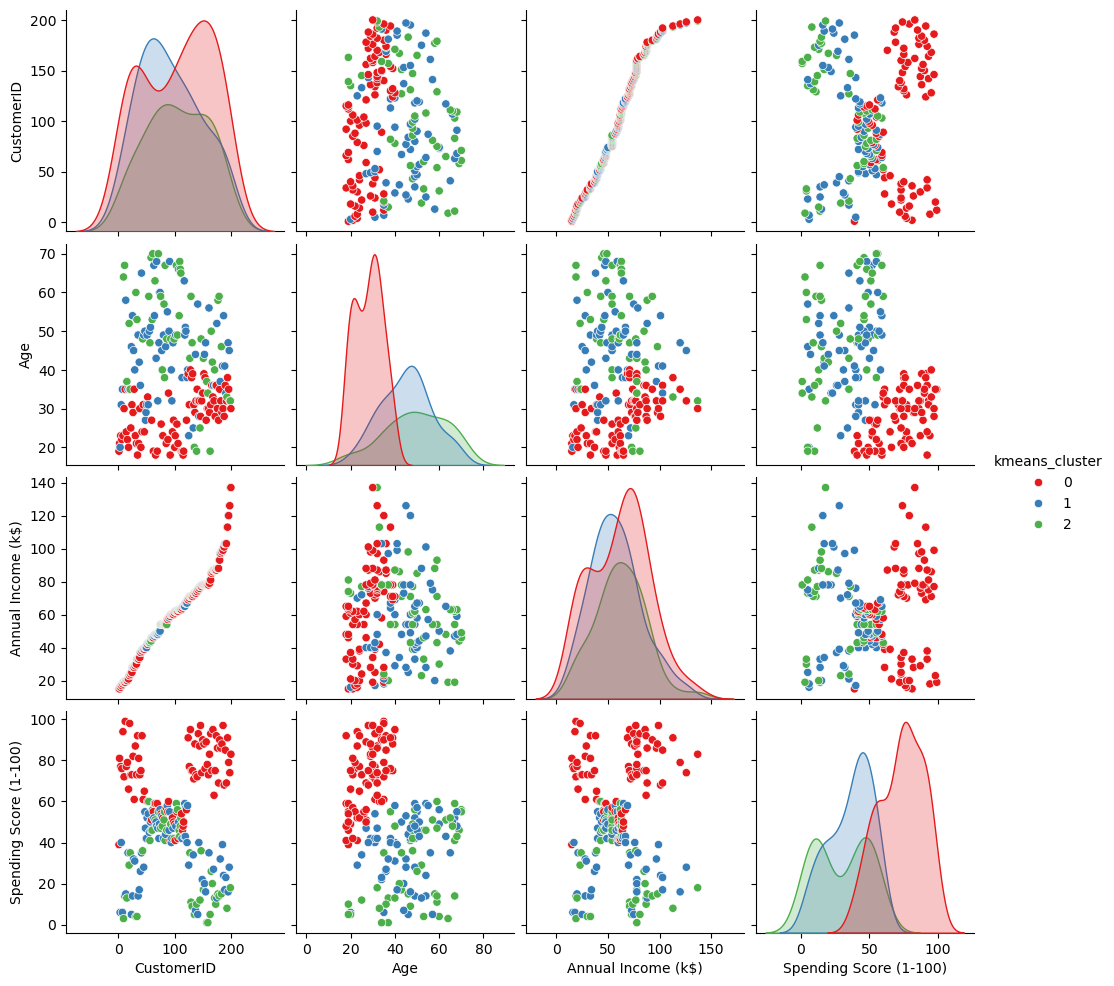

In [31]:
import seaborn as sns
sns.pairplot(df_out, hue="kmeans_cluster", palette="Set1")

In [32]:
df_out.groupby("kmeans_cluster")['Gender'].value_counts()

kmeans_cluster  Gender
0               Female    46
                Male      39
1               Female    66
2               Male      49
Name: count, dtype: int64

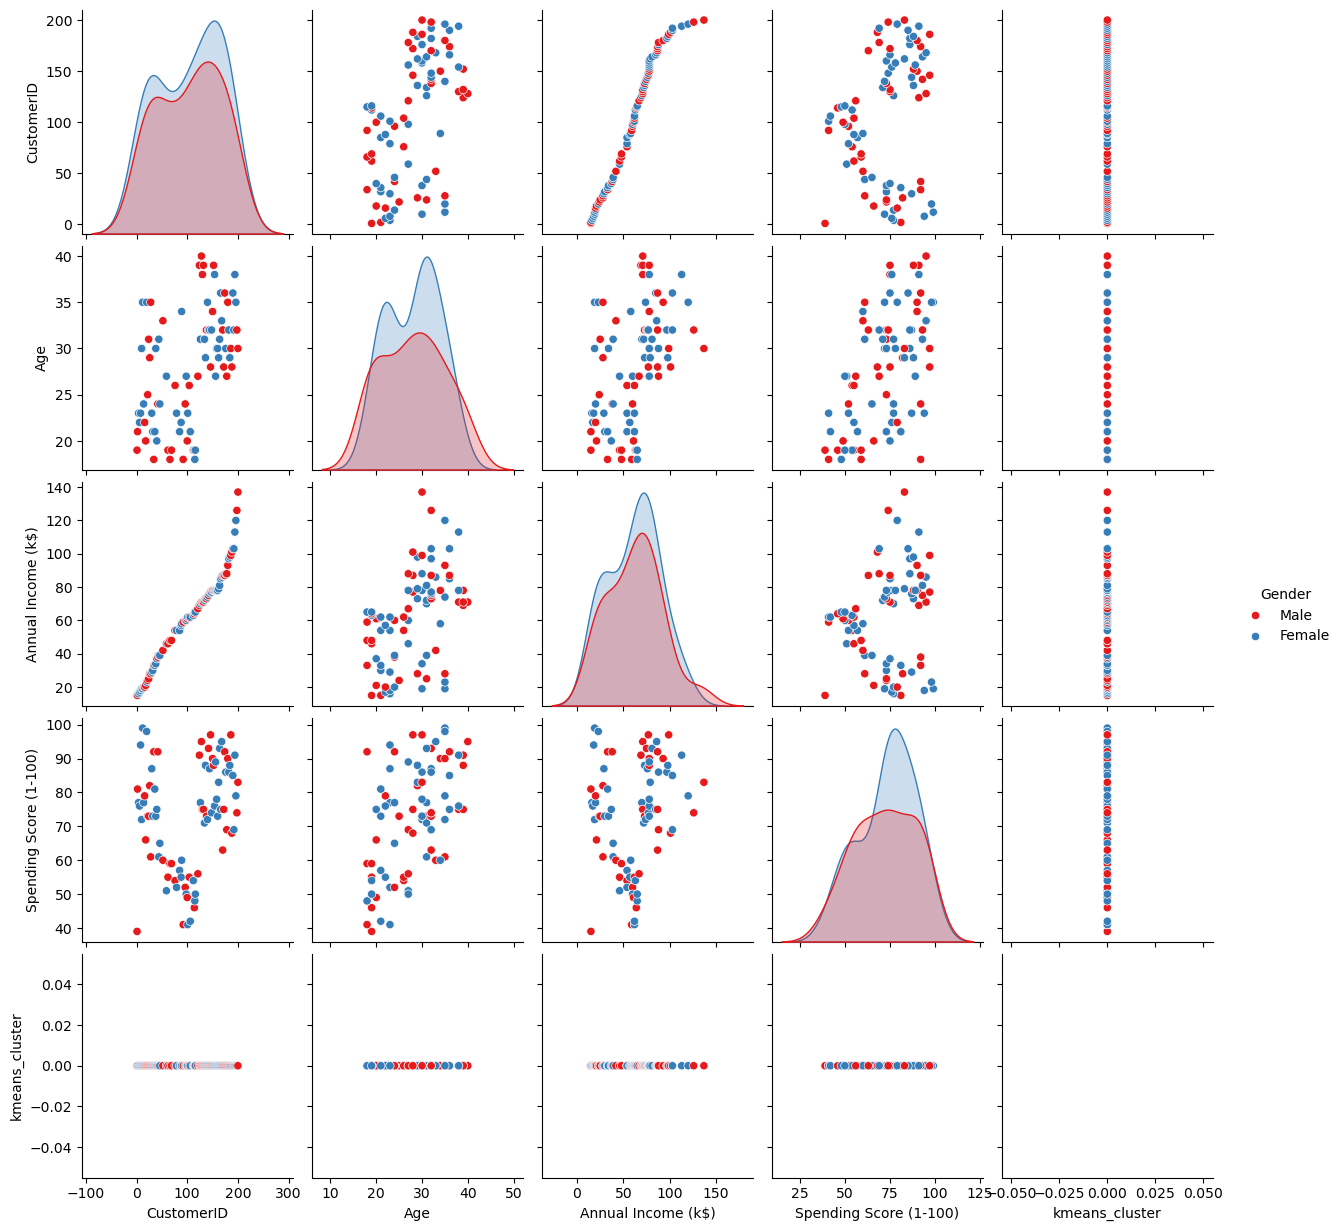

In [33]:
sns.pairplot(df_out[df_out["kmeans_cluster"] == 0], hue="Gender", palette="Set1")

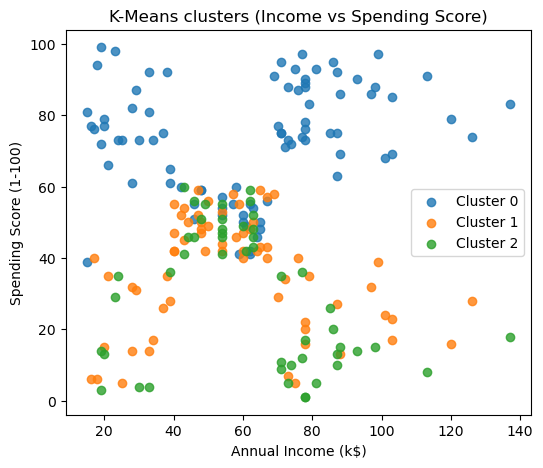

In [34]:

# Visualize clusters on the classic 2D plane: Income vs Spending Score
plt.figure(figsize=(6,5))
for c in sorted(df_out["kmeans_cluster"].unique()):
    mask = df_out["kmeans_cluster"] == c
    plt.scatter(df_out.loc[mask, "Annual Income (k$)"],
                df_out.loc[mask, "Spending Score (1-100)"],
                label=f"Cluster {c}", alpha=0.8)

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("K-Means clusters (Income vs Spending Score)")
plt.legend()
plt.show()


### 5.3 Optional: visualize in 2D using PCA

If you use more than 2 features, PCA gives a quick 2D view of cluster structure.


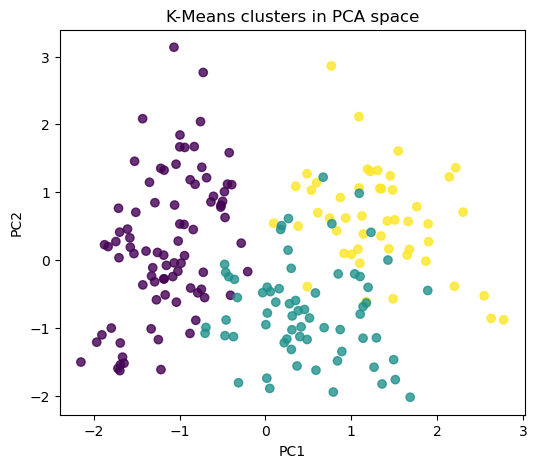

array([0.33690046, 0.26230645])

In [35]:

from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(6,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=kmeans_labels, alpha=0.8)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("K-Means clusters in PCA space")
plt.show()

pca.explained_variance_ratio_


## 6) DBSCAN clustering

DBSCAN finds dense regions and labels isolated points as **noise** (`-1`).

Key hyperparameters:
- `eps`: neighborhood radius
- `min_samples`: points required to form a dense region

A common practical trick: look at a **k-distance plot** to pick `eps`.


In [ ]:

from sklearn.neighbors import NearestNeighbors

# k-distance plot (k = min_samples)
min_samples = 5
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)

# Sort distances to the k-th nearest neighbor
k_dist = np.sort(distances[:, -1])

plt.figure(figsize=(6,4))
plt.plot(k_dist)
plt.grid(True)
plt.xlabel("Points sorted by distance")
plt.ylabel(f"Distance to {min_samples}th nearest neighbor")
plt.title("k-distance plot (use this to choose eps)")
plt.show()


In [ ]:

from sklearn.cluster import DBSCAN

# TODO (students): pick eps by inspecting the k-distance plot
eps = 0.8

dbscan = DBSCAN(eps=eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(X_scaled)

# Count clusters (excluding noise = -1)
n_noise = (db_labels == -1).sum()
n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)

n_clusters, n_noise


In [ ]:

# Add DBSCAN labels to output dataframe
df_out["dbscan_cluster"] = db_labels
df_out["dbscan_cluster"].value_counts().sort_index()


In [ ]:

# Visualize DBSCAN result on Income vs Spending Score (noise shown as x markers)
plt.figure(figsize=(6,5))

noise_mask = df_out["dbscan_cluster"] == -1
plt.scatter(df_out.loc[noise_mask, "Annual Income (k$)"],
            df_out.loc[noise_mask, "Spending Score (1-100)"],
            marker="x", label="Noise (-1)", alpha=0.8)

for c in sorted([c for c in df_out["dbscan_cluster"].unique() if c != -1]):
    mask = df_out["dbscan_cluster"] == c
    plt.scatter(df_out.loc[mask, "Annual Income (k$)"],
                df_out.loc[mask, "Spending Score (1-100)"],
                label=f"Cluster {c}", alpha=0.8)

plt.xlabel("Annual Income (k$)")
plt.ylabel("Spending Score (1-100)")
plt.title("DBSCAN clusters (Income vs Spending Score)")
plt.legend()
plt.show()


## 7) Quick comparison + prompts

- **K-Means** forces every point into one of `k` clusters.
- **DBSCAN** can leave points as noise and can find non-spherical clusters.

### Prompts (for students)
1. Try clustering with only the 2 classic features: `Annual Income (k$)` and `Spending Score (1-100)`. How do results change?
2. How sensitive is DBSCAN to `eps`? Find an `eps` that produces:
   - too many noise points,
   - and too few (everything in one blob).
3. Add a cluster-quality metric like silhouette score for K-Means (optional extension).
